# Visualize something
Hypothesis: contextualized LMs encode syntax and semantics in different subspaces.  
For this notebook: check the (scalar / vector) distance of these pairs:  
- The factor of tense (syntax category). emb("I have eaten") - emb("I am eating")  
- The factor of subject (semantic category). emb("I think this is true") - emb("The professor thinks this is true")  
- The factor of discourse (pragmatics category). emb("This tweet involves racism") - emb("Although I highly respect Yann, this tweet involves racism")

In [1]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import os, sys, time, re
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=False)

def evaluate_contextual_diff(pair):
    source, target = pair[0], pair[1]
    src_ids = torch.tensor(bert_tokenizer.encode(source)).unsqueeze(0)
    src_vec = bert_model(src_ids)[0].mean(dim=1)[0]  # (768,) torch.tensor
    
    tgt_ids = torch.tensor(bert_tokenizer.encode(target)).unsqueeze(0)
    tgt_vec = bert_model(tgt_ids)[0].mean(dim=1)[0]
    
    d_emb = len(src_vec)  # 768
    diff = src_vec - tgt_vec
    return diff  # 768-dimensional torch.tensor

In [3]:
pairs_past_to_present = [
    ("I have eaten.", "I am eating."),
    ("He has eaten.", "He eats."),
    ("We went to school.", "We go to school."),
    ("Mary wrote a blog.", "Mary is writing a blog."),
    ("The classrooms were clean.", "The classrooms are clean.")
]

pairs_vary_subject = [
    ("I read.", "He reads."),
    ("I was doing projects.", "She was doing projects."),
    ("Donald will drink water tomorrow.", "Joe will drink water tomorrow."),
    ("We are preparing dinner.", "You are preparing dinner."),
    ("You should eat an apple a day. This is beneficial for your health.", "Tom should eat an apple a day. This is beneficial for his health.")
]

pairs_add_concession = [
    ("This involves racism", "Although I respect his work, his tweet involves racism."),
    ("You failed your exam", "Although you tried hard, you failed your exam."),
    ("Your ideas are fake", "Your reasoning is valid, but your ideas are fake."),
    ("Bubble tea is unhealthy", "Bubble tea is delicious, but they are unhealthy."),
    ("This kid does not do well in the exam.", "This kid is smart, but he does not do well in the exam.")
]

vecs_time = torch.stack([evaluate_contextual_diff(pair) for pair in pairs_past_to_present])
vecs_subject = torch.stack([evaluate_contextual_diff(pair) for pair in pairs_vary_subject])
vecs_concess = torch.stack([evaluate_contextual_diff(pair) for pair in pairs_add_concession])

In [4]:
def pca_embed(vecs):
    pca = PCA(n_components=2)
    return pca.fit_transform(vecs.detach().numpy())

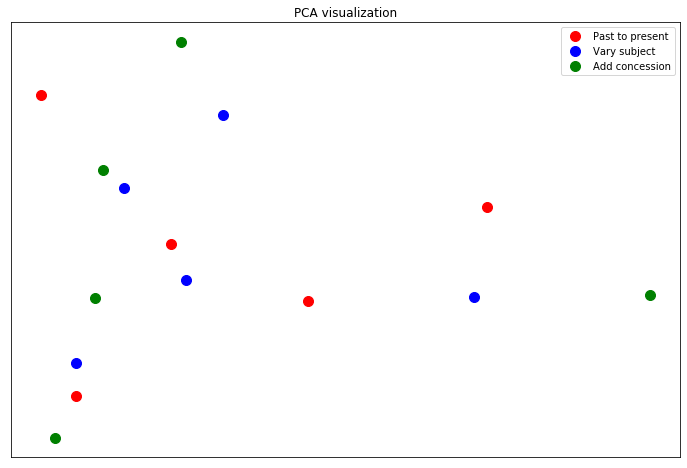

In [5]:
def make_plot(collections, names):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    palette = [colors["red"], colors["blue"], colors["green"], colors["purple"]][:len(names)]
    for i, pairs in enumerate(collections):
        vecs = torch.stack([evaluate_contextual_diff(pair) for pair in pairs])
        z = pca_embed(vecs)  # (n_pt, 2)
        ax.plot(z[:, 0], z[:, 1], "o", c=palette[i], markersize=10, label=names[i])
        
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.legend()
    plt.title('PCA visualization')
    plt.show()
    
collections = [pairs_past_to_present, pairs_vary_subject, pairs_add_concession]
names = ["Past to present", "Vary subject", "Add concession"]
make_plot(collections, names)

They are not very separable from 2D visualization. Let me see if I can compute their directionality.

In [6]:
# If cosine similarity is close to 0, the two vectors are more orthogonal.
def check_orthogonality(vecs1, vecs2):
    v1 = vecs1.mean(dim=0).detach().numpy()
    v2 = vecs2.mean(dim=0).detach().numpy()
    return cosine_similarity([v1], [v2])[0][0]

print ("Time vs Subject:", end="\t")
print(check_orthogonality(vecs_time, vecs_subject))
print ("Time vs Concession:", end="\t")
print (check_orthogonality(vecs_time, vecs_concess))
print ("Subject vs Concession:", end="\t")
print (check_orthogonality(vecs_subject, vecs_concess))

Time vs Subject:	0.20844
Time vs Concession:	-0.11634992
Subject vs Concession:	-0.10156865
